<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\melnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=64, num_heads=2, ff_dim=64, num_transformer_blocks=2,dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.reshape = nn.Flatten(start_dim=2)  # Reshaping as in TensorFlow's Reshape
        self.embedding = nn.Linear(input_shape[1] * input_shape[2], embed_dim)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate=dropout_rate) for _ in range(num_transformer_blocks)]
        )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.reshape(x)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # PyTorch uses (seq_len, batch, embed_dim) format for transformers
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = x.permute(1, 2, 0)  # Back to (batch, embed_dim, seq_len)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.classifier(x)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:
model  = TransformerModel(input_shape=(224,224,3),num_classes=3) # declare model here
randomdata = torch.randn((1,224,224,3))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TransformerModel                                             --
├─Flatten: 1-1                                               --
├─Linear: 1-2                                                43,072
├─ModuleList: 1-3                                            --
│    └─TransformerBlock: 2-1                                 --
│    │    └─MultiheadAttention: 3-1                          16,640
│    │    └─Sequential: 3-2                                  8,320
│    │    └─LayerNorm: 3-3                                   128
│    │    └─LayerNorm: 3-4                                   128
│    │    └─Dropout: 3-5                                     --
│    │    └─Dropout: 3-6                                     --
│    └─TransformerBlock: 2-2                                 --
│    │    └─MultiheadAttention: 3-7                          16,640
│    │    └─Sequential: 3-8                                  8,320
│    │    └─Lay

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters:0 {'hyperparameters': {'ff_dim': 32, 'dropout_rate': 0.11542281673201528, 'embed_dim': 256, 'learning_rate': 5.726209095539437e-05, 'weight_decay': 4.566099590369729e-05, 'batch_size': 16, 'num_heads': 2, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4947}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1213, Accuracy: 0.3693
Validation Loss: 1.0296, Validation Accuracy: 0.4784
Epoch [2/100], Loss: 1.0705, Accuracy: 0.4447
Validation Loss: 0.9763, Validation Accuracy: 0.4589
Epoch [3/100], Loss: 1.0385, Accuracy: 0.5219
Validation Loss: 1.0206, Validation Accuracy: 0.5214
Epoch [4/100], Loss: 1.0134, Accuracy: 0.5536
Validation Loss: 0.9762, Validation Accuracy: 0.5534
Epoch [5/100], Loss: 0.9991, Accuracy: 0.59

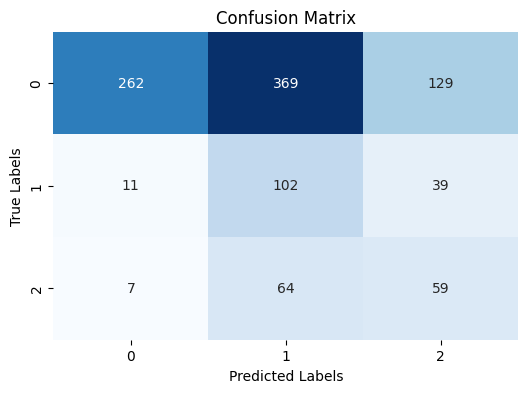


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 262/760 (34.47%)
Class 1: Correct Predictions / Total True Samples = 102/152 (67.11%)
Class 2: Correct Predictions / Total True Samples = 59/130 (45.38%)

Precision-Recall Curves:


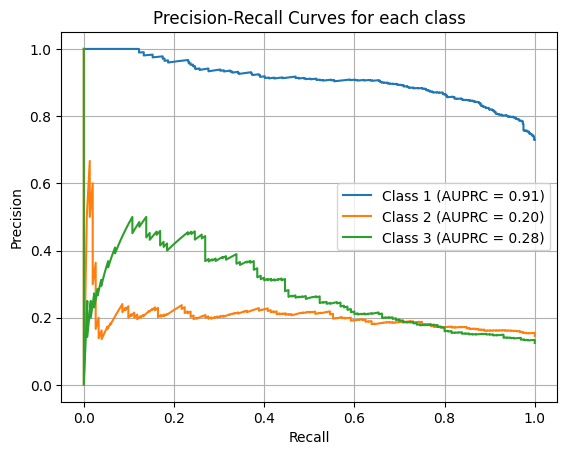


ROC Curves:


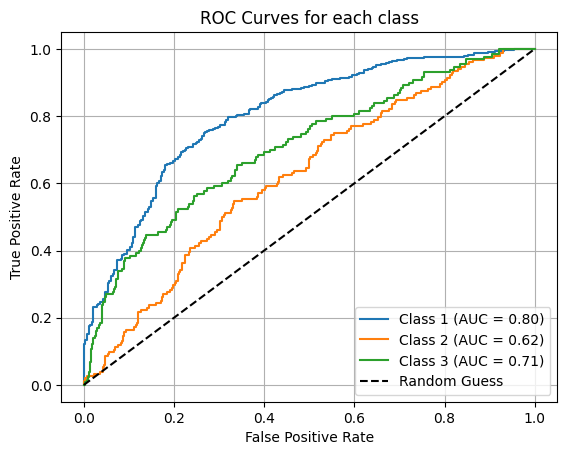


Mean F1 Score: 0.3771
Balanced Accuracy: 0.4899
Average AUPRC: 0.4627

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.34      0.50       760
           1       0.19      0.67      0.30       152
           2       0.26      0.45      0.33       130

    accuracy                           0.41      1042
   macro avg       0.46      0.49      0.38      1042
weighted avg       0.74      0.41      0.45      1042

Fold No: 2
Epoch [1/100], Loss: 1.1583, Accuracy: 0.3418
Validation Loss: 1.1646, Validation Accuracy: 0.3910
Epoch [2/100], Loss: 1.1043, Accuracy: 0.3868
Validation Loss: 1.0924, Validation Accuracy: 0.3631
Epoch [3/100], Loss: 1.0952, Accuracy: 0.4037
Validation Loss: 1.1009, Validation Accuracy: 0.4019
Epoch [4/100], Loss: 1.0735, Accuracy: 0.4512
Validation Loss: 1.0603, Validation Accuracy: 0.3487
Epoch [5/100], Loss: 1.0417, Accuracy: 0.5140
Validation Loss: 1.1777, Validation Accuracy: 0.4114
Epoch [6/100], Los

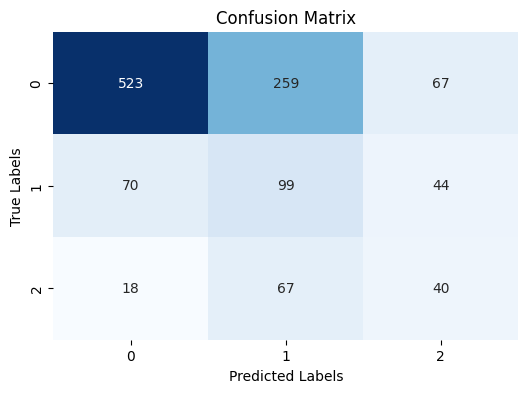


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 523/849 (61.60%)
Class 1: Correct Predictions / Total True Samples = 99/213 (46.48%)
Class 2: Correct Predictions / Total True Samples = 40/125 (32.00%)

Precision-Recall Curves:


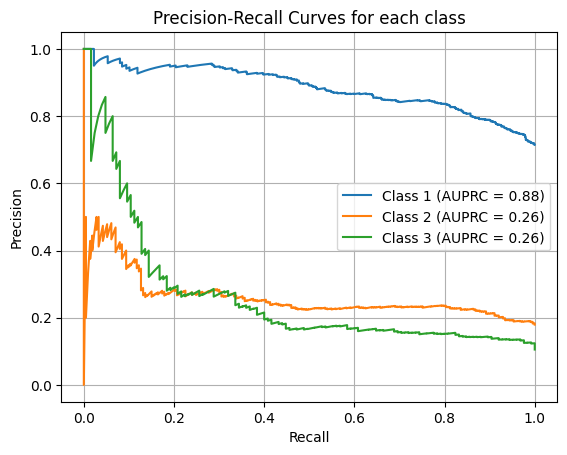


ROC Curves:


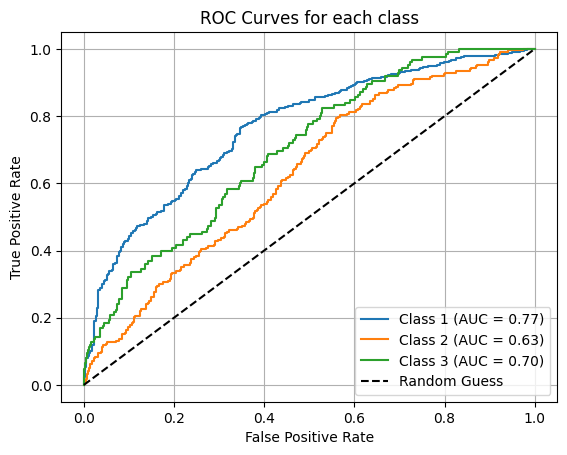


Mean F1 Score: 0.4389
Balanced Accuracy: 0.4669
Average AUPRC: 0.4680

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       849
           1       0.23      0.46      0.31       213
           2       0.26      0.32      0.29       125

    accuracy                           0.56      1187
   macro avg       0.45      0.47      0.44      1187
weighted avg       0.68      0.56      0.60      1187

Fold No: 3
Epoch [1/100], Loss: 1.2250, Accuracy: 0.3701
Validation Loss: 1.0589, Validation Accuracy: 0.4033
Epoch [2/100], Loss: 1.0843, Accuracy: 0.4243
Validation Loss: 0.9962, Validation Accuracy: 0.3997
Epoch [3/100], Loss: 1.0793, Accuracy: 0.4540
Validation Loss: 1.0489, Validation Accuracy: 0.4668
Epoch [4/100], Loss: 1.0380, Accuracy: 0.5204
Validation Loss: 1.1717, Validation Accuracy: 0.3780
Epoch [5/100], Loss: 1.0129, Accuracy: 0.5603
Validation Loss: 1.1039, Validation Accuracy: 0.4575
Epoch [6/100], Los

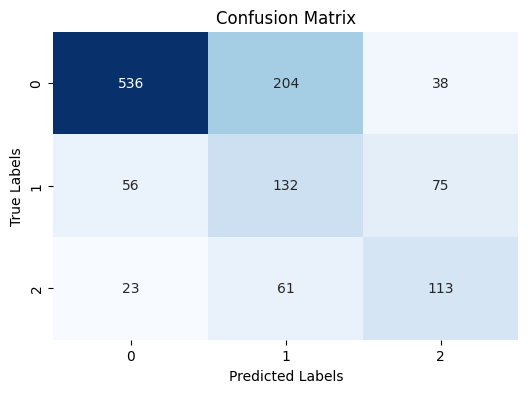


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 536/778 (68.89%)
Class 1: Correct Predictions / Total True Samples = 132/263 (50.19%)
Class 2: Correct Predictions / Total True Samples = 113/197 (57.36%)

Precision-Recall Curves:


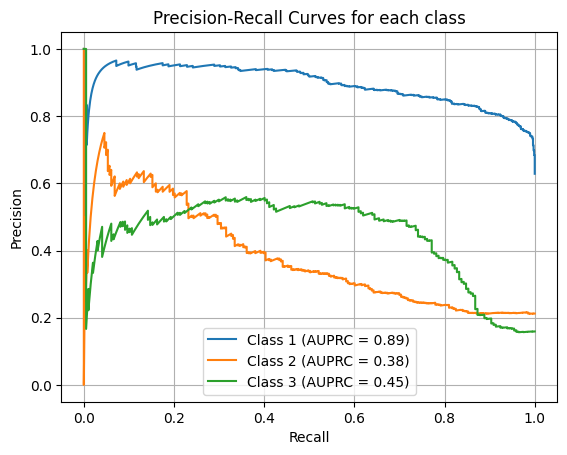


ROC Curves:


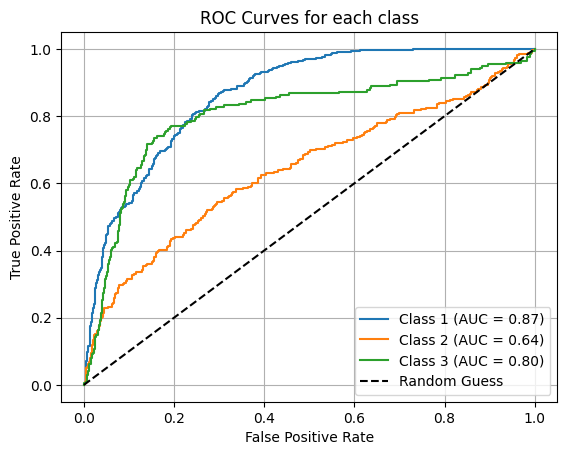


Mean F1 Score: 0.5679
Balanced Accuracy: 0.5882
Average AUPRC: 0.5730

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       778
           1       0.33      0.50      0.40       263
           2       0.50      0.57      0.53       197

    accuracy                           0.63      1238
   macro avg       0.57      0.59      0.57      1238
weighted avg       0.70      0.63      0.65      1238

Fold No: 4
Epoch [1/100], Loss: 1.1648, Accuracy: 0.3542
Validation Loss: 1.1944, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1080, Accuracy: 0.3602
Validation Loss: 1.0254, Validation Accuracy: 0.3409
Epoch [3/100], Loss: 1.0897, Accuracy: 0.4019
Validation Loss: 1.0828, Validation Accuracy: 0.4172
Epoch [4/100], Loss: 1.0776, Accuracy: 0.4531
Validation Loss: 1.0230, Validation Accuracy: 0.5058
Epoch [5/100], Loss: 1.0344, Accuracy: 0.5286
Validation Loss: 1.0289, Validation Accuracy: 0.5132
Epoch [6/100], Los

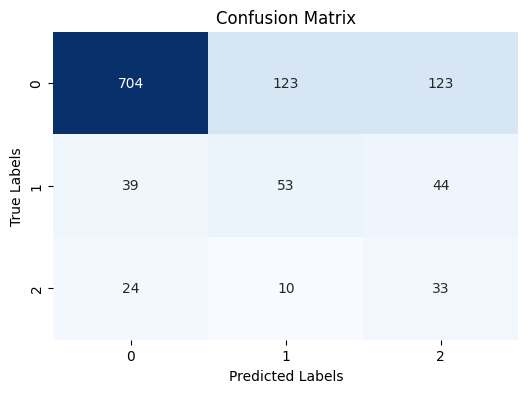


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 704/950 (74.11%)
Class 1: Correct Predictions / Total True Samples = 53/136 (38.97%)
Class 2: Correct Predictions / Total True Samples = 33/67 (49.25%)

Precision-Recall Curves:


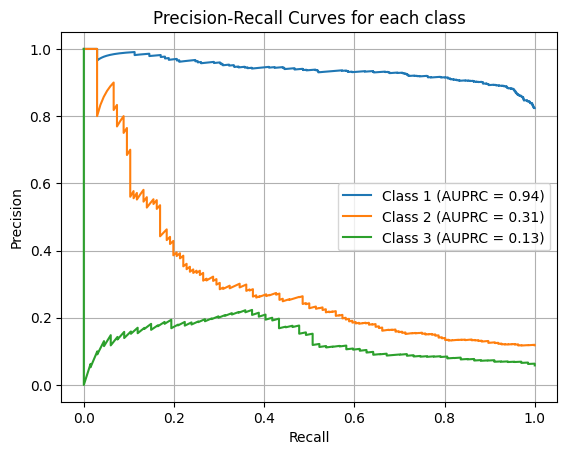


ROC Curves:


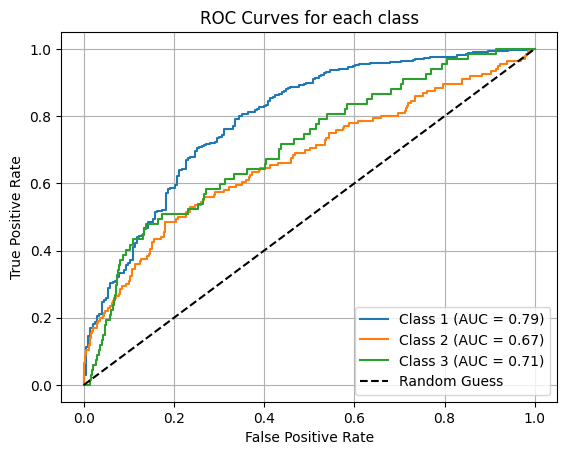


Mean F1 Score: 0.4655
Balanced Accuracy: 0.5411
Average AUPRC: 0.4583

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       950
           1       0.28      0.39      0.33       136
           2       0.17      0.49      0.25        67

    accuracy                           0.69      1153
   macro avg       0.46      0.54      0.47      1153
weighted avg       0.80      0.69      0.73      1153

Fold No: 5
Epoch [1/100], Loss: 1.1438, Accuracy: 0.3429
Validation Loss: 1.1399, Validation Accuracy: 0.4139
Epoch [2/100], Loss: 1.1078, Accuracy: 0.3820
Validation Loss: 0.9396, Validation Accuracy: 0.3510
Epoch [3/100], Loss: 1.0785, Accuracy: 0.4285
Validation Loss: 1.1252, Validation Accuracy: 0.4240
Epoch [4/100], Loss: 1.0720, Accuracy: 0.4609
Validation Loss: 1.0753, Validation Accuracy: 0.4524
Epoch [5/100], Loss: 1.0295, Accuracy: 0.5354
Validation Loss: 0.9280, Validation Accuracy: 0.5224
Epoch [6/100], Los

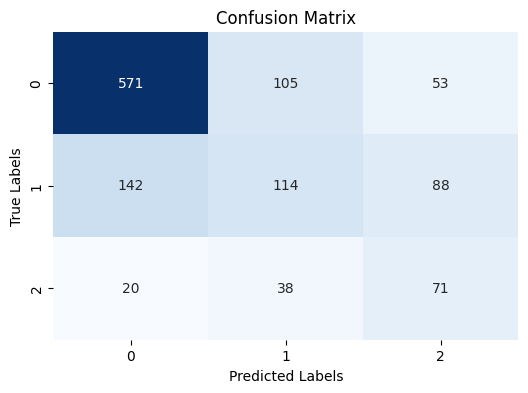


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 571/729 (78.33%)
Class 1: Correct Predictions / Total True Samples = 114/344 (33.14%)
Class 2: Correct Predictions / Total True Samples = 71/129 (55.04%)

Precision-Recall Curves:


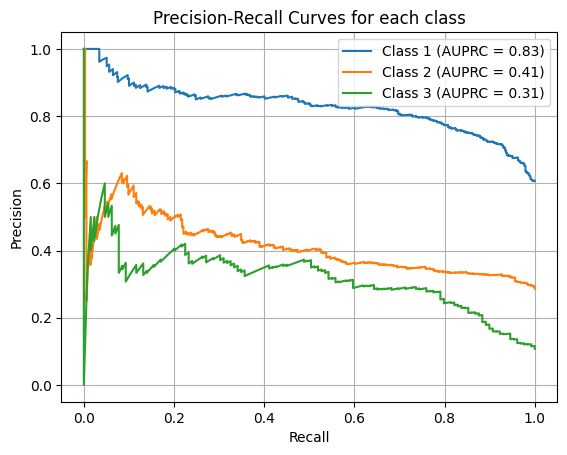


ROC Curves:


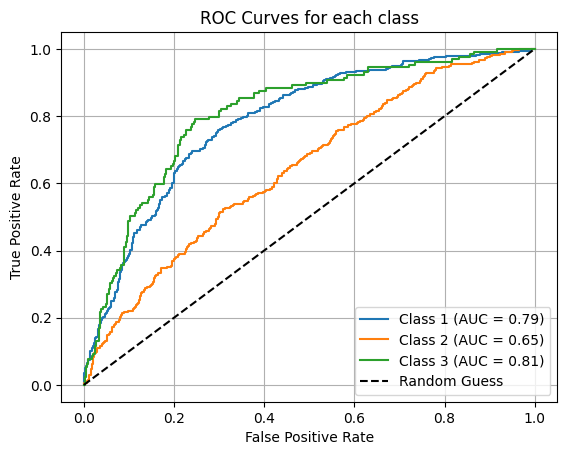


Mean F1 Score: 0.5256
Balanced Accuracy: 0.5550
Average AUPRC: 0.5175

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       729
           1       0.44      0.33      0.38       344
           2       0.33      0.55      0.42       129

    accuracy                           0.63      1202
   macro avg       0.52      0.56      0.53      1202
weighted avg       0.64      0.63      0.63      1202

Accuracy for each fold: [np.float64(0.4898785425101215), np.float64(0.4669358593650636), np.float64(0.5881504056740936), np.float64(0.5410986091215748), np.float64(0.5550158973213811)]
AUPRC for each fold: [np.float64(0.46265965347307486), np.float64(0.46795650715901366), np.float64(0.572986966166457), np.float64(0.4583427609745834), np.float64(0.5174948113436603)]
Average AUPRC across all folds: 0.49588813982335783
Average Balanced Accuracy across all folds: 0.528215862798447


TypeError: save_results_to_csv() got an unexpected keyword argument 'save_path'. Did you mean 'csv_path'?

In [ ]:
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.11542281673201528, 'embed_dim': 256, 'learning_rate': 5.726209095539437e-05, 'weight_decay': 4.566099590369729e-05, 'batch_size': 16, 'num_heads': 2, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4947},
    {'hyperparameters':{'ff_dim': 512, 'dropout_rate': 0.29722015100615246, 'embed_dim': 64, 'learning_rate': 0.00046269394870735754, 'weight_decay': 0.00011711458551829446, 'batch_size': 10, 'num_heads': 4, 'num_transformer_blocks': 1}, 'mean_accuracy': 0.4893},
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.1069229904003147, 'embed_dim': 256, 'learning_rate': 0.00015525256911280537, 'weight_decay': 3.149880823421316e-05, 'batch_size': 16, 'num_heads': 4, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4884},
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.10945213351235199, 'embed_dim': 256, 'learning_rate': 0.00015701457915942213, 'weight_decay': 2.5321469842206672e-05, 'batch_size': 16, 'num_heads': 4, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4841},
    {'hyperparameters':{'ff_dim': 256, 'dropout_rate': 0.2051768973953511, 'embed_dim': 128, 'learning_rate': 0.00011833585465114953, 'weight_decay': 1.384051137092256e-05, 'batch_size': 10, 'num_heads': 2, 'num_transformer_blocks': 8}, 'mean_accuracy': 0.4759}
]


for param_id in range(len(top_params)):
    # Fold indices and other configurations
    
    print(f"Running experiment with parameters:{param_id} {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    learning_rate = 0.0001
    epochs = 100
    input_shape = (3, 224, 224)  # (channels, height, width)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'




    embed_dim = top_params[param_id]["hyperparameters"]["embed_dim"]
    learning_rate = top_params[param_id]["hyperparameters"]["learning_rate"]
    num_heads = top_params[param_id]["hyperparameters"]["num_heads"]
    ff_dim = top_params[param_id]["hyperparameters"]["ff_dim"]
    num_transformer_blocks = top_params[param_id]["hyperparameters"]["num_transformer_blocks"]
    dropout_rate = top_params[param_id]["hyperparameters"]["dropout_rate"]
    batch_size = top_params[param_id]["hyperparameters"]["batch_size"]
    weight_decay = top_params[param_id]["hyperparameters"]["weight_decay"]

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        
        



    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TransformerModel(input_shape=input_shape, num_classes=num_classes,
                                    embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks, dropout_rate=dropout_rate).to(device)

        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
        
    # Save all results to CSV
    save_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv"
    model_description = f"TRANSformer MEL top5 param#{param_id} 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description, save_results_to_csv_path=save_path)
    
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)  

<h1> parameters set 2 to 5

Running experiment with parameters:1 {'hyperparameters': {'ff_dim': 512, 'dropout_rate': 0.29722015100615246, 'embed_dim': 64, 'learning_rate': 0.00046269394870735754, 'weight_decay': 0.00011711458551829446, 'batch_size': 10, 'num_heads': 4, 'num_transformer_blocks': 1}, 'mean_accuracy': 0.4893}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1619, Accuracy: 0.3302
Validation Loss: 1.0882, Validation Accuracy: 0.3580
Epoch [2/100], Loss: 1.1091, Accuracy: 0.3427
Validation Loss: 1.1403, Validation Accuracy: 0.3909
Epoch [3/100], Loss: 1.1096, Accuracy: 0.3313
Validation Loss: 1.1093, Validation Accuracy: 0.4054
Epoch [4/100], Loss: 1.1062, Accuracy: 0.3416
Validation Loss: 1.0538, Validation Accuracy: 0.3669
Epoch [5/100], Loss: 1.1079, Accuracy: 0.

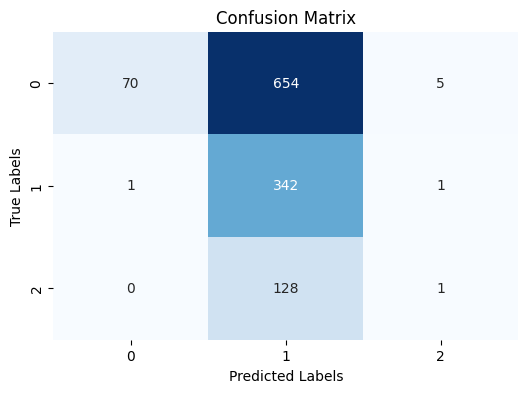


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 70/729 (9.60%)
Class 1: Correct Predictions / Total True Samples = 342/344 (99.42%)
Class 2: Correct Predictions / Total True Samples = 1/129 (0.78%)

Precision-Recall Curves:


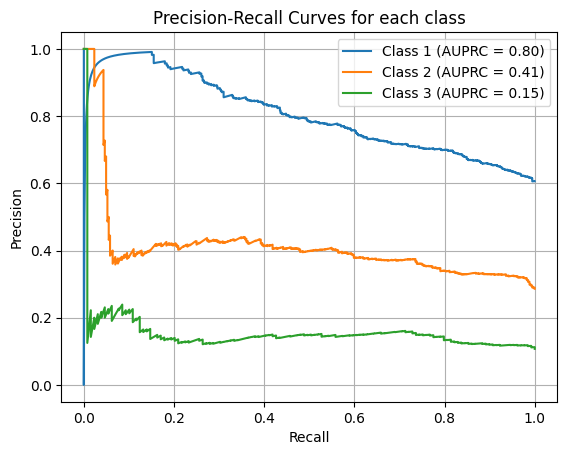


ROC Curves:


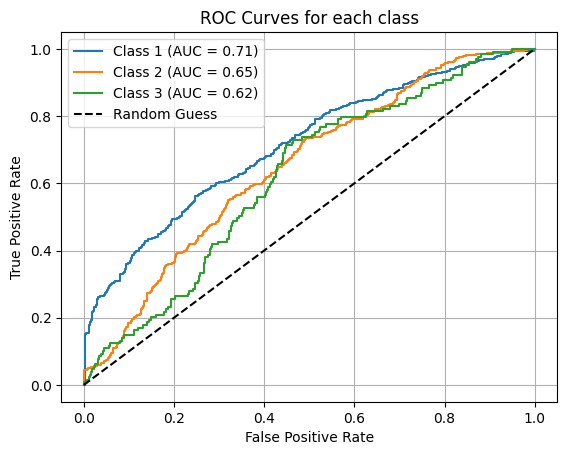


Mean F1 Score: 0.2185
Balanced Accuracy: 0.3660
Average AUPRC: 0.4553

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.10      0.17       729
           1       0.30      0.99      0.47       344
           2       0.14      0.01      0.01       129

    accuracy                           0.34      1202
   macro avg       0.48      0.37      0.22      1202
weighted avg       0.70      0.34      0.24      1202

Fold No: 2
Epoch [1/100], Loss: 1.1207, Accuracy: 0.3673
Validation Loss: 1.0683, Validation Accuracy: 0.4644
Epoch [2/100], Loss: 1.0881, Accuracy: 0.4145
Validation Loss: 1.0412, Validation Accuracy: 0.4171
Epoch [3/100], Loss: 1.1005, Accuracy: 0.4078
Validation Loss: 1.0935, Validation Accuracy: 0.4890
Epoch [4/100], Loss: 1.0931, Accuracy: 0.3850
Validation Loss: 1.0937, Validation Accuracy: 0.3688
Epoch [5/100], Loss: 1.0960, Accuracy: 0.3916
Validation Loss: 1.0729, Validation Accuracy: 0.3443
Epoch [6/100], Los

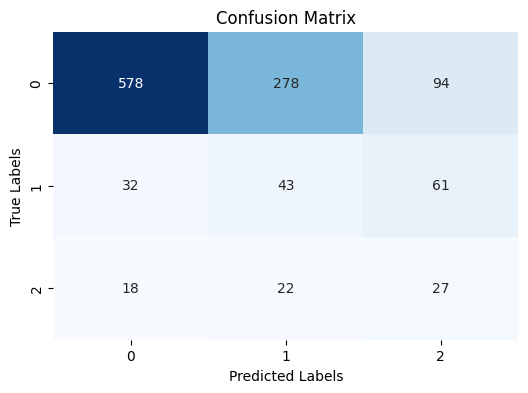


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 578/950 (60.84%)
Class 1: Correct Predictions / Total True Samples = 43/136 (31.62%)
Class 2: Correct Predictions / Total True Samples = 27/67 (40.30%)

Precision-Recall Curves:


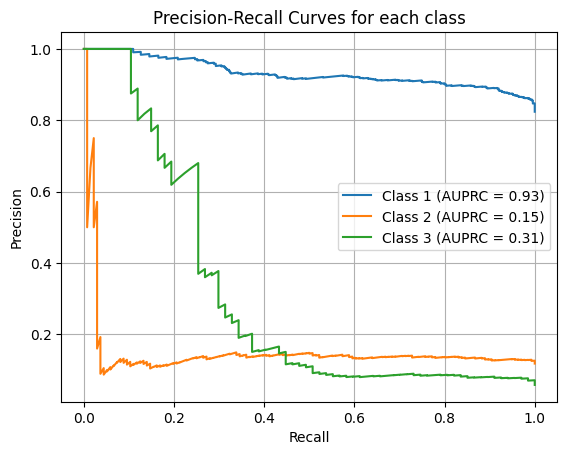


ROC Curves:


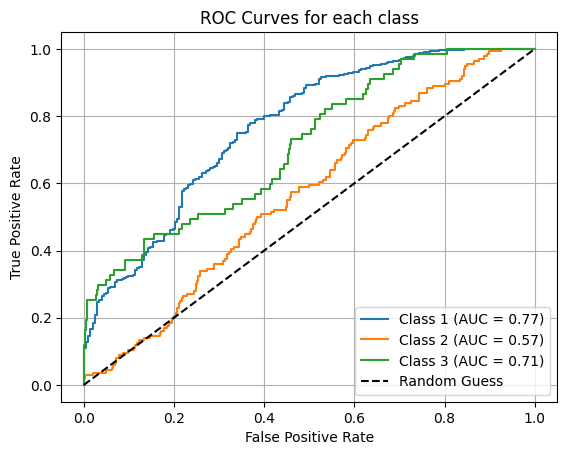


Mean F1 Score: 0.3763
Balanced Accuracy: 0.4425
Average AUPRC: 0.4626

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       950
           1       0.13      0.32      0.18       136
           2       0.15      0.40      0.22        67

    accuracy                           0.56      1153
   macro avg       0.40      0.44      0.38      1153
weighted avg       0.78      0.56      0.64      1153

Fold No: 3
Epoch [1/100], Loss: 1.1197, Accuracy: 0.3422
Validation Loss: 1.1623, Validation Accuracy: 0.3449
Epoch [2/100], Loss: 1.0825, Accuracy: 0.4265
Validation Loss: 1.0202, Validation Accuracy: 0.4042
Epoch [3/100], Loss: 1.0455, Accuracy: 0.5018
Validation Loss: 1.2026, Validation Accuracy: 0.3587
Epoch [4/100], Loss: 1.0614, Accuracy: 0.4715
Validation Loss: 0.9712, Validation Accuracy: 0.4474
Epoch [5/100], Loss: 1.0249, Accuracy: 0.5255
Validation Loss: 1.0654, Validation Accuracy: 0.4570
Epoch [6/100], Los

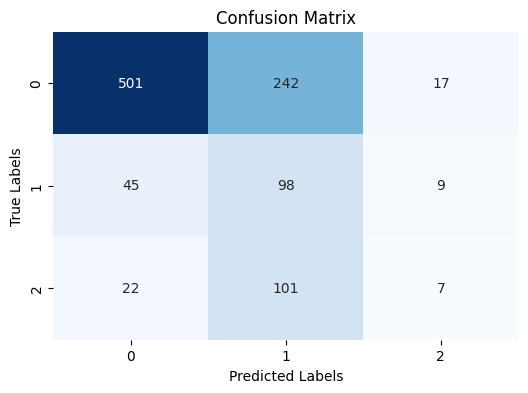


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 501/760 (65.92%)
Class 1: Correct Predictions / Total True Samples = 98/152 (64.47%)
Class 2: Correct Predictions / Total True Samples = 7/130 (5.38%)

Precision-Recall Curves:


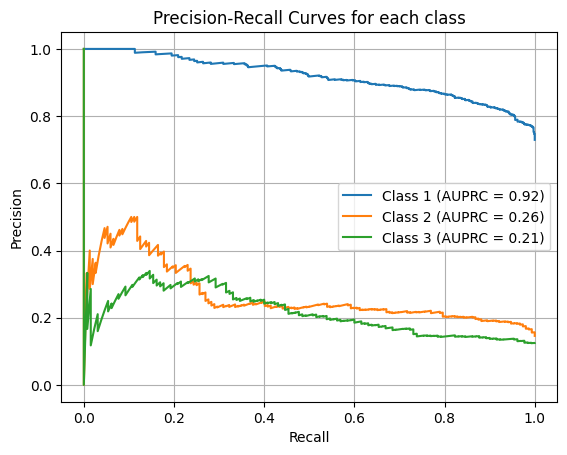


ROC Curves:


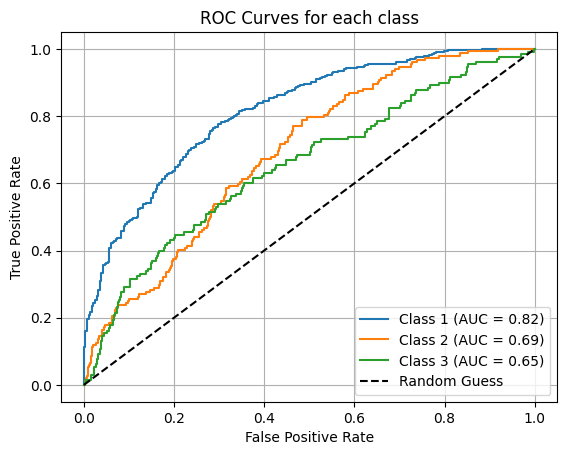


Mean F1 Score: 0.3903
Balanced Accuracy: 0.4526
Average AUPRC: 0.4645

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       760
           1       0.22      0.64      0.33       152
           2       0.21      0.05      0.09       130

    accuracy                           0.58      1042
   macro avg       0.44      0.45      0.39      1042
weighted avg       0.70      0.58      0.61      1042

Fold No: 4
Epoch [1/100], Loss: 1.1544, Accuracy: 0.3333
Validation Loss: 1.2003, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1029, Accuracy: 0.3427
Validation Loss: 1.1431, Validation Accuracy: 0.3062
Epoch [3/100], Loss: 1.1027, Accuracy: 0.3630
Validation Loss: 1.1739, Validation Accuracy: 0.3057
Epoch [4/100], Loss: 1.0888, Accuracy: 0.3953
Validation Loss: 1.0721, Validation Accuracy: 0.4072
Epoch [5/100], Loss: 1.0540, Accuracy: 0.4894
Validation Loss: 1.0287, Validation Accuracy: 0.4276
Epoch [6/100], Los

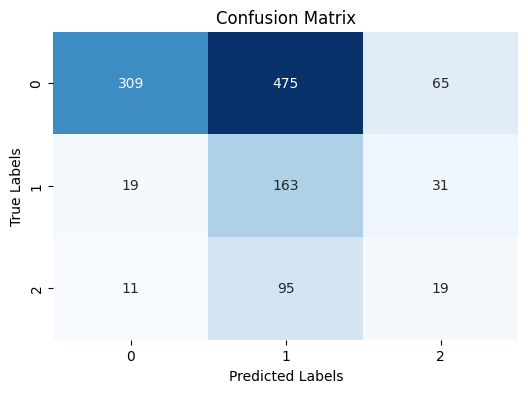


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 309/849 (36.40%)
Class 1: Correct Predictions / Total True Samples = 163/213 (76.53%)
Class 2: Correct Predictions / Total True Samples = 19/125 (15.20%)

Precision-Recall Curves:


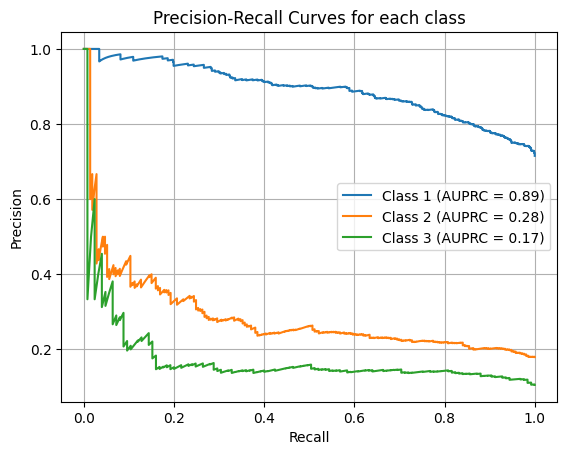


ROC Curves:


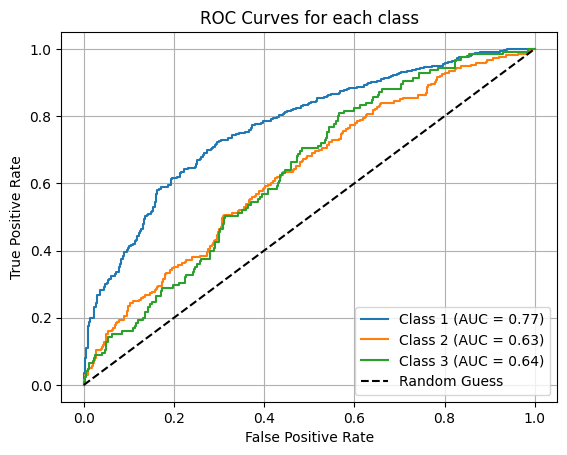


Mean F1 Score: 0.3410
Balanced Accuracy: 0.4271
Average AUPRC: 0.4489

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.36      0.52       849
           1       0.22      0.77      0.34       213
           2       0.17      0.15      0.16       125

    accuracy                           0.41      1187
   macro avg       0.43      0.43      0.34      1187
weighted avg       0.71      0.41      0.45      1187

Fold No: 5
Epoch [1/100], Loss: 1.1082, Accuracy: 0.4110
Validation Loss: 1.0981, Validation Accuracy: 0.3281
Epoch [2/100], Loss: 1.1006, Accuracy: 0.3722
Validation Loss: 1.0919, Validation Accuracy: 0.3672
Epoch [3/100], Loss: 1.0825, Accuracy: 0.4407
Validation Loss: 1.0990, Validation Accuracy: 0.3713
Epoch [4/100], Loss: 1.0862, Accuracy: 0.4274
Validation Loss: 1.1608, Validation Accuracy: 0.3521
Epoch [5/100], Loss: 1.0755, Accuracy: 0.4366
Validation Loss: 1.0582, Validation Accuracy: 0.4675
Epoch [6/100], Los

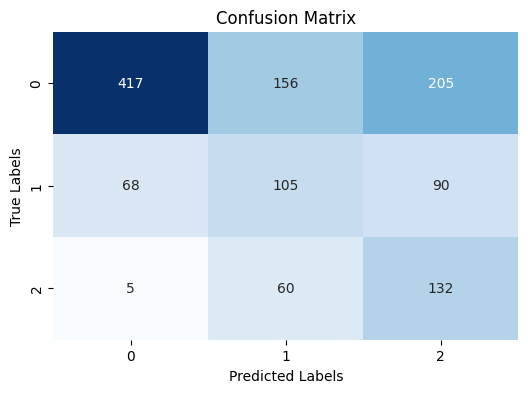


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 417/778 (53.60%)
Class 1: Correct Predictions / Total True Samples = 105/263 (39.92%)
Class 2: Correct Predictions / Total True Samples = 132/197 (67.01%)

Precision-Recall Curves:


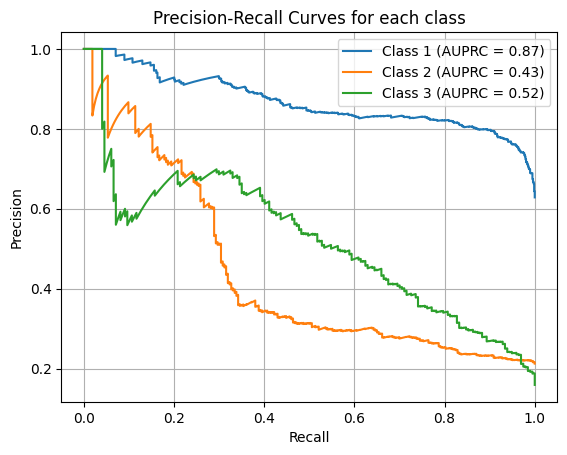


ROC Curves:


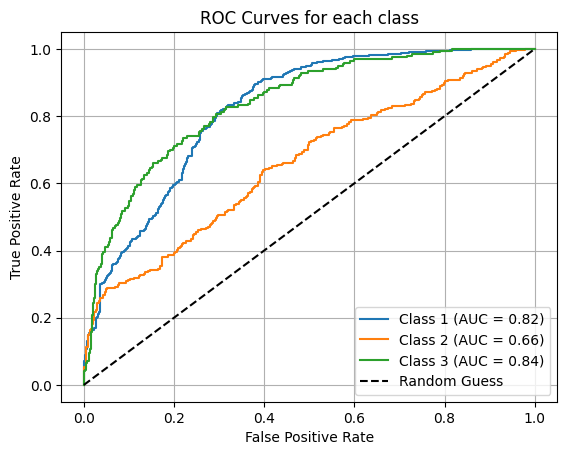


Mean F1 Score: 0.4801
Balanced Accuracy: 0.5351
Average AUPRC: 0.6073

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       778
           1       0.33      0.40      0.36       263
           2       0.31      0.67      0.42       197

    accuracy                           0.53      1238
   macro avg       0.50      0.54      0.48      1238
weighted avg       0.65      0.53      0.56      1238

Accuracy for each fold: [np.float64(0.36598664412330795), np.float64(0.44252753261556), np.float64(0.45259784075573556), np.float64(0.4270719377118621), np.float64(0.535093340790402)]
AUPRC for each fold: [np.float64(0.45529333129817456), np.float64(0.4625615160594097), np.float64(0.4645425062365162), np.float64(0.4489068568659715), np.float64(0.607250255598296)]
Average AUPRC across all folds: 0.48771089321167366
Average Balanced Accuracy across all folds: 0.44465545919937355
Results saved to D:\PYTHONIG\newwindow\NOT

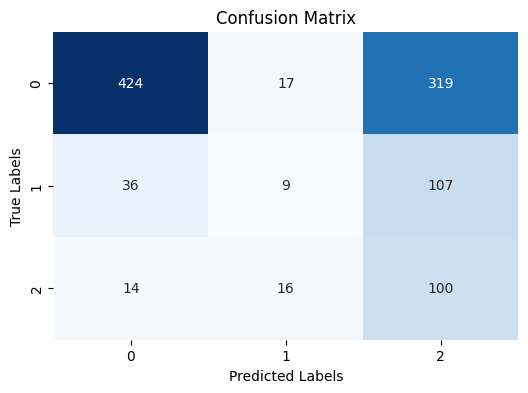


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 424/760 (55.79%)
Class 1: Correct Predictions / Total True Samples = 9/152 (5.92%)
Class 2: Correct Predictions / Total True Samples = 100/130 (76.92%)

Precision-Recall Curves:


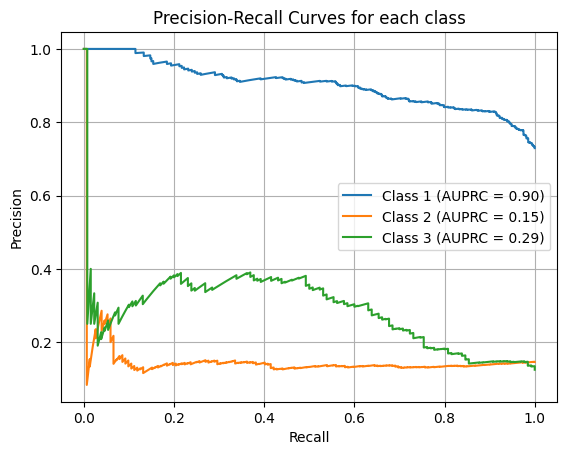


ROC Curves:


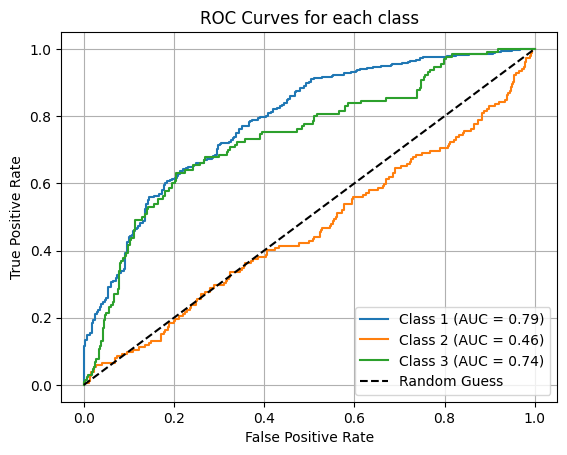


Mean F1 Score: 0.3616
Balanced Accuracy: 0.4621
Average AUPRC: 0.4452

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       760
           1       0.21      0.06      0.09       152
           2       0.19      0.77      0.30       130

    accuracy                           0.51      1042
   macro avg       0.43      0.46      0.36      1042
weighted avg       0.71      0.51      0.55      1042

Fold No: 2
Epoch [1/100], Loss: 1.1705, Accuracy: 0.3319
Validation Loss: 1.1009, Validation Accuracy: 0.3581
Epoch [2/100], Loss: 1.1133, Accuracy: 0.3622
Validation Loss: 1.0664, Validation Accuracy: 0.3279
Epoch [3/100], Loss: 1.1203, Accuracy: 0.3518
Validation Loss: 1.0803, Validation Accuracy: 0.3390
Epoch [4/100], Loss: 1.1031, Accuracy: 0.3732
Validation Loss: 0.9620, Validation Accuracy: 0.3355
Epoch [5/100], Loss: 1.0857, Accuracy: 0.4139
Validation Loss: 0.9908, Validation Accuracy: 0.3984
Epoch [6/100], Los

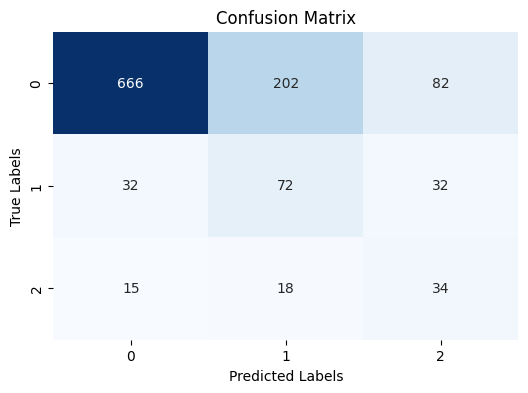


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 666/950 (70.11%)
Class 1: Correct Predictions / Total True Samples = 72/136 (52.94%)
Class 2: Correct Predictions / Total True Samples = 34/67 (50.75%)

Precision-Recall Curves:


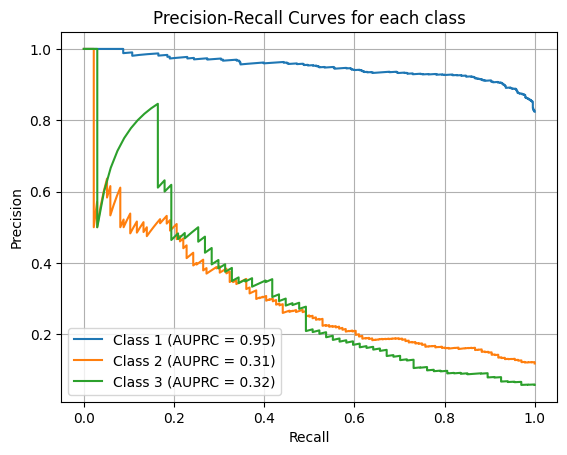


ROC Curves:


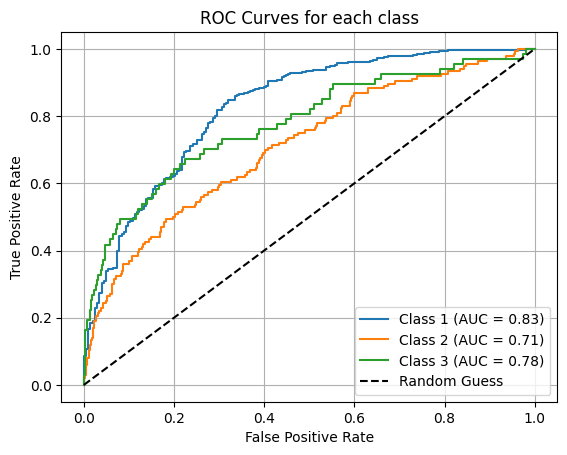


Mean F1 Score: 0.4846
Balanced Accuracy: 0.5793
Average AUPRC: 0.5265

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       950
           1       0.25      0.53      0.34       136
           2       0.23      0.51      0.32        67

    accuracy                           0.67      1153
   macro avg       0.47      0.58      0.48      1153
weighted avg       0.81      0.67      0.72      1153

Fold No: 3
Epoch [1/100], Loss: 1.1502, Accuracy: 0.3589
Validation Loss: 1.2532, Validation Accuracy: 0.3340
Epoch [2/100], Loss: 1.1011, Accuracy: 0.3889
Validation Loss: 1.0694, Validation Accuracy: 0.4211
Epoch [3/100], Loss: 1.0799, Accuracy: 0.4474
Validation Loss: 1.1780, Validation Accuracy: 0.4369
Epoch [4/100], Loss: 1.0546, Accuracy: 0.4898
Validation Loss: 1.0634, Validation Accuracy: 0.4699
Epoch [5/100], Loss: 1.0073, Accuracy: 0.5782
Validation Loss: 1.0812, Validation Accuracy: 0.4886
Epoch [6/100], Los

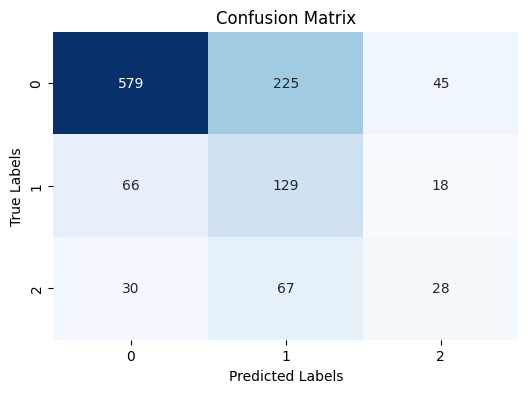


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 579/849 (68.20%)
Class 1: Correct Predictions / Total True Samples = 129/213 (60.56%)
Class 2: Correct Predictions / Total True Samples = 28/125 (22.40%)

Precision-Recall Curves:


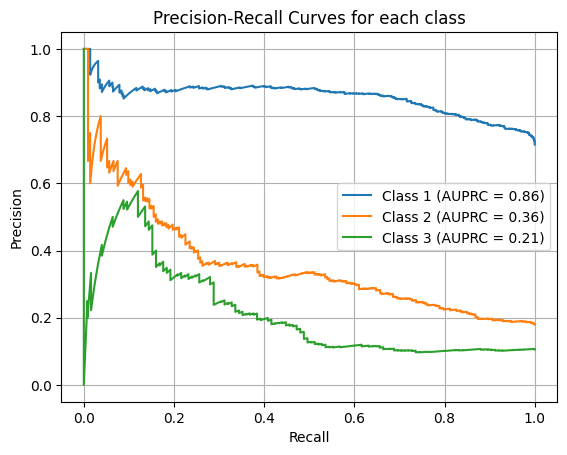


ROC Curves:


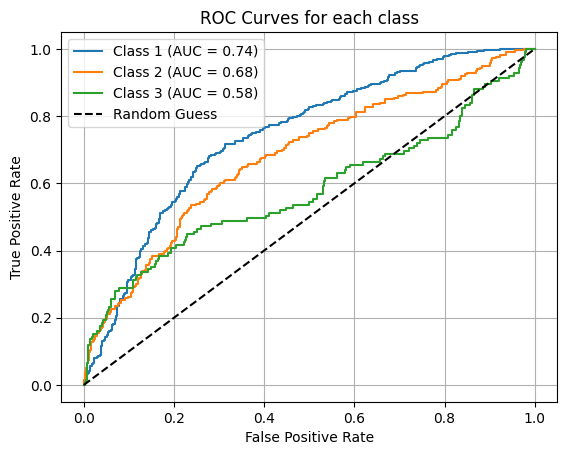


Mean F1 Score: 0.4753
Balanced Accuracy: 0.5039
Average AUPRC: 0.4734

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       849
           1       0.31      0.61      0.41       213
           2       0.31      0.22      0.26       125

    accuracy                           0.62      1187
   macro avg       0.49      0.50      0.48      1187
weighted avg       0.70      0.62      0.64      1187

Fold No: 4
Epoch [1/100], Loss: 1.1960, Accuracy: 0.3671
Validation Loss: 1.3453, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1051, Accuracy: 0.3671
Validation Loss: 1.1359, Validation Accuracy: 0.3056
Epoch [3/100], Loss: 1.0986, Accuracy: 0.3814
Validation Loss: 1.1718, Validation Accuracy: 0.3428
Epoch [4/100], Loss: 1.1022, Accuracy: 0.3906
Validation Loss: 1.0323, Validation Accuracy: 0.4102
Epoch [5/100], Loss: 1.0873, Accuracy: 0.4601
Validation Loss: 1.0829, Validation Accuracy: 0.3861
Epoch [6/100], Los

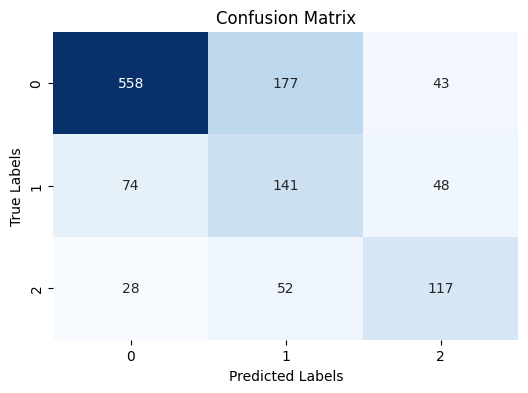


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 558/778 (71.72%)
Class 1: Correct Predictions / Total True Samples = 141/263 (53.61%)
Class 2: Correct Predictions / Total True Samples = 117/197 (59.39%)

Precision-Recall Curves:


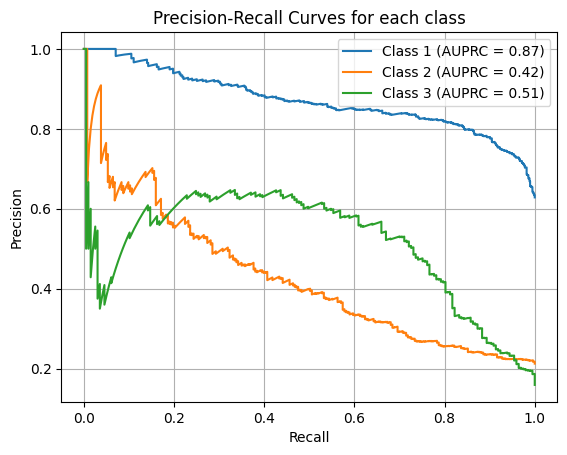


ROC Curves:


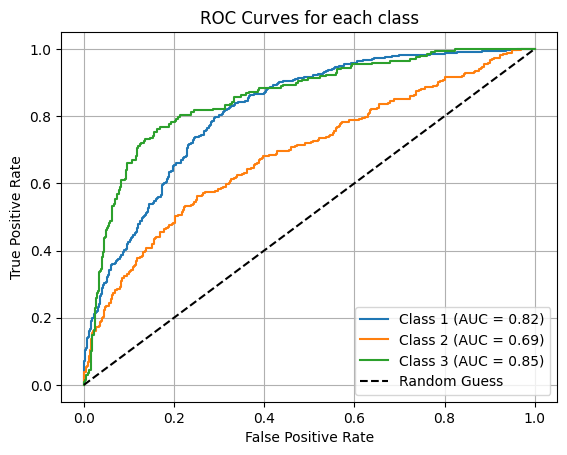


Mean F1 Score: 0.5998
Balanced Accuracy: 0.6158
Average AUPRC: 0.6024

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       778
           1       0.38      0.54      0.45       263
           2       0.56      0.59      0.58       197

    accuracy                           0.66      1238
   macro avg       0.60      0.62      0.60      1238
weighted avg       0.70      0.66      0.67      1238

Fold No: 5
Epoch [1/100], Loss: 1.2010, Accuracy: 0.3323
Validation Loss: 1.0499, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1233, Accuracy: 0.3364
Validation Loss: 1.0893, Validation Accuracy: 0.4006
Epoch [3/100], Loss: 1.1197, Accuracy: 0.3509
Validation Loss: 1.0510, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1068, Accuracy: 0.3747
Validation Loss: 1.0403, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1194, Accuracy: 0.3478
Validation Loss: 1.0793, Validation Accuracy: 0.4232
Epoch [6/100], Los

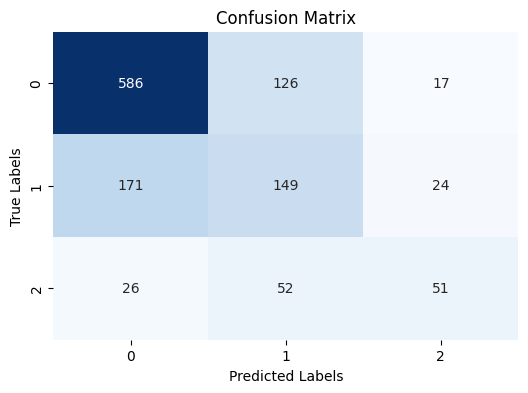


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 586/729 (80.38%)
Class 1: Correct Predictions / Total True Samples = 149/344 (43.31%)
Class 2: Correct Predictions / Total True Samples = 51/129 (39.53%)

Precision-Recall Curves:


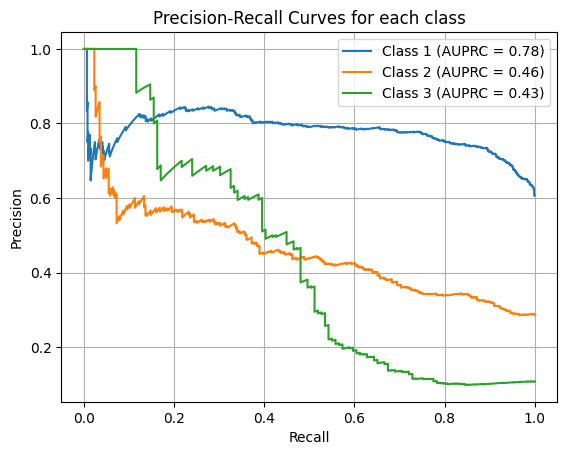


ROC Curves:


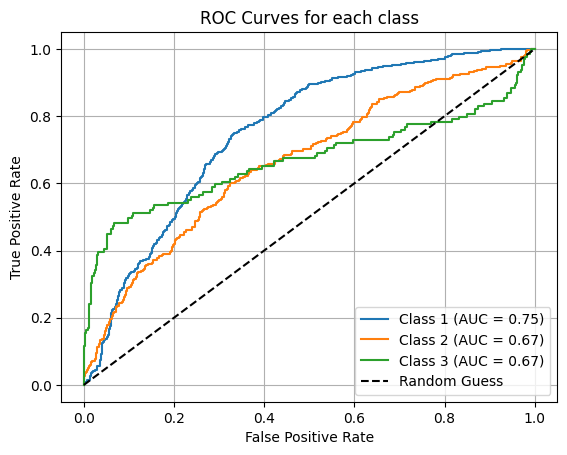


Mean F1 Score: 0.5603
Balanced Accuracy: 0.5441
Average AUPRC: 0.5575

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       729
           1       0.46      0.43      0.44       344
           2       0.55      0.40      0.46       129

    accuracy                           0.65      1202
   macro avg       0.59      0.54      0.56      1202
weighted avg       0.64      0.65      0.65      1202

Accuracy for each fold: [np.float64(0.46211201079622133), np.float64(0.5793090276173314), np.float64(0.5038708671344913), np.float64(0.6157513176103436), np.float64(0.5441097500026585)]
AUPRC for each fold: [np.float64(0.44517488423098417), np.float64(0.5264816025496005), np.float64(0.47340489661315294), np.float64(0.6024027029561562), np.float64(0.5575338029935605)]
Average AUPRC across all folds: 0.5209995778686908
Average Balanced Accuracy across all folds: 0.5410305946322091
Results saved to D:\PYTHONIG\newwindow\N

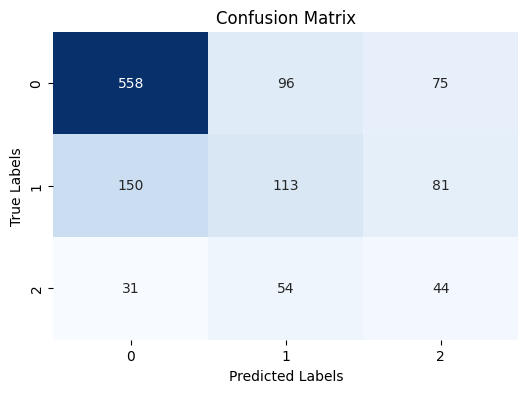


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 558/729 (76.54%)
Class 1: Correct Predictions / Total True Samples = 113/344 (32.85%)
Class 2: Correct Predictions / Total True Samples = 44/129 (34.11%)

Precision-Recall Curves:


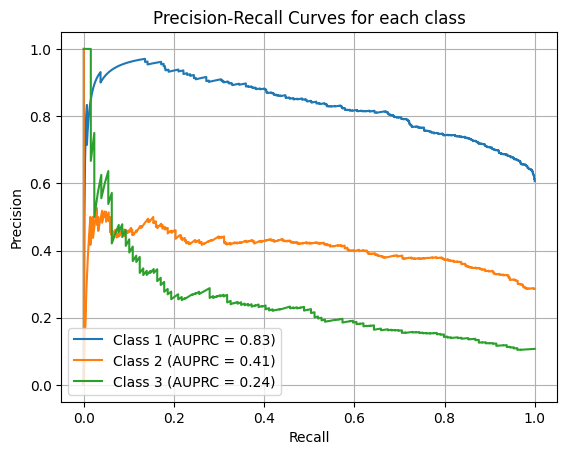


ROC Curves:


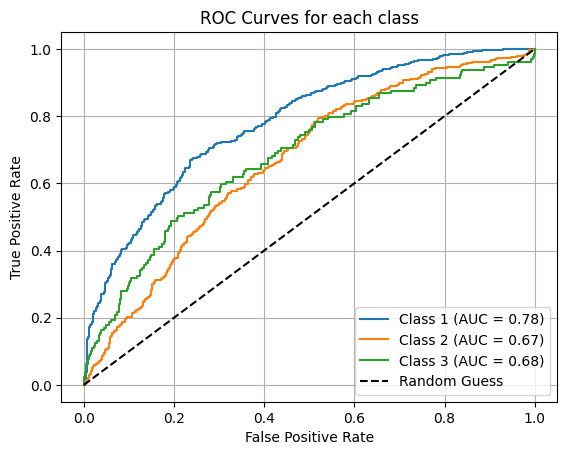


Mean F1 Score: 0.4667
Balanced Accuracy: 0.4783
Average AUPRC: 0.4942

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       729
           1       0.43      0.33      0.37       344
           2       0.22      0.34      0.27       129

    accuracy                           0.59      1202
   macro avg       0.47      0.48      0.47      1202
weighted avg       0.60      0.59      0.60      1202

Fold No: 2
Epoch [1/100], Loss: 1.1769, Accuracy: 0.3545
Validation Loss: 1.0794, Validation Accuracy: 0.4072
Epoch [2/100], Loss: 1.1073, Accuracy: 0.3579
Validation Loss: 1.0740, Validation Accuracy: 0.4357
Epoch [3/100], Loss: 1.1170, Accuracy: 0.3503
Validation Loss: 1.0805, Validation Accuracy: 0.3338
Epoch [4/100], Loss: 1.1043, Accuracy: 0.3553
Validation Loss: 1.0027, Validation Accuracy: 0.4697
Epoch [5/100], Loss: 1.0709, Accuracy: 0.4475
Validation Loss: 1.2168, Validation Accuracy: 0.3444
Epoch [6/100], Los

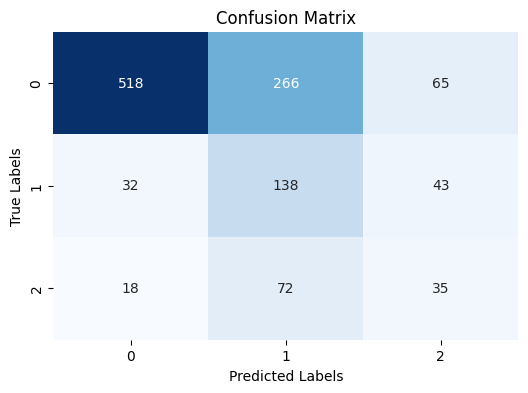


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 518/849 (61.01%)
Class 1: Correct Predictions / Total True Samples = 138/213 (64.79%)
Class 2: Correct Predictions / Total True Samples = 35/125 (28.00%)

Precision-Recall Curves:


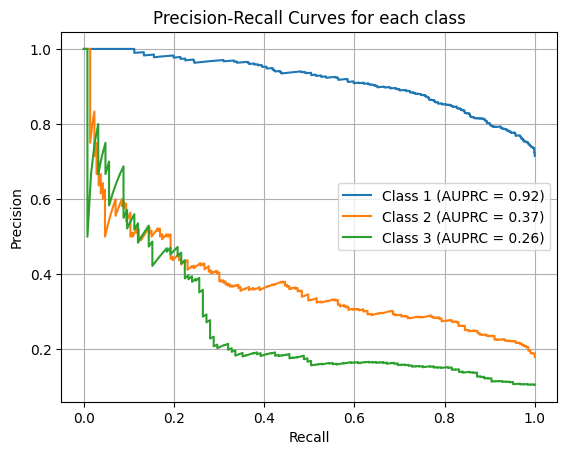


ROC Curves:


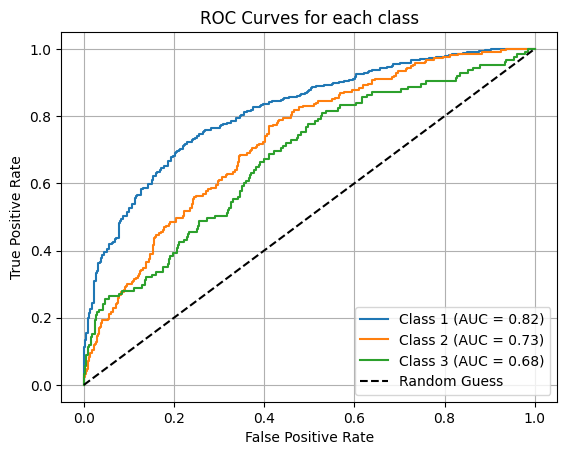


Mean F1 Score: 0.4643
Balanced Accuracy: 0.5127
Average AUPRC: 0.5165

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       849
           1       0.29      0.65      0.40       213
           2       0.24      0.28      0.26       125

    accuracy                           0.58      1187
   macro avg       0.48      0.51      0.46      1187
weighted avg       0.73      0.58      0.62      1187

Fold No: 3
Epoch [1/100], Loss: 1.1829, Accuracy: 0.3435
Validation Loss: 1.0328, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1237, Accuracy: 0.3596
Validation Loss: 1.1029, Validation Accuracy: 0.3089
Epoch [3/100], Loss: 1.1024, Accuracy: 0.3656
Validation Loss: 1.1816, Validation Accuracy: 0.3604
Epoch [4/100], Loss: 1.1102, Accuracy: 0.3851
Validation Loss: 1.0536, Validation Accuracy: 0.4037
Epoch [5/100], Loss: 1.0812, Accuracy: 0.4334
Validation Loss: 0.9558, Validation Accuracy: 0.4078
Epoch [6/100], Los

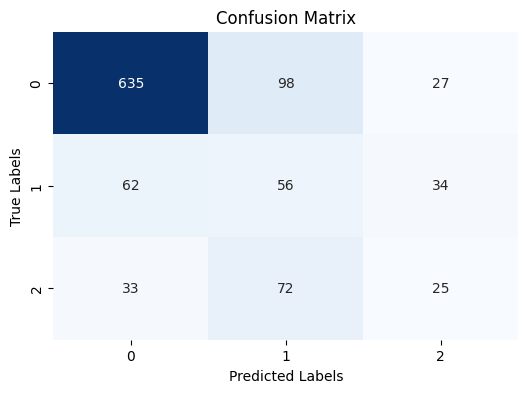


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 635/760 (83.55%)
Class 1: Correct Predictions / Total True Samples = 56/152 (36.84%)
Class 2: Correct Predictions / Total True Samples = 25/130 (19.23%)

Precision-Recall Curves:


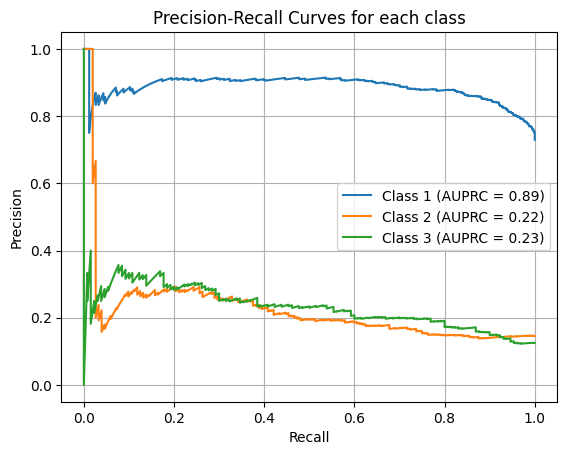


ROC Curves:


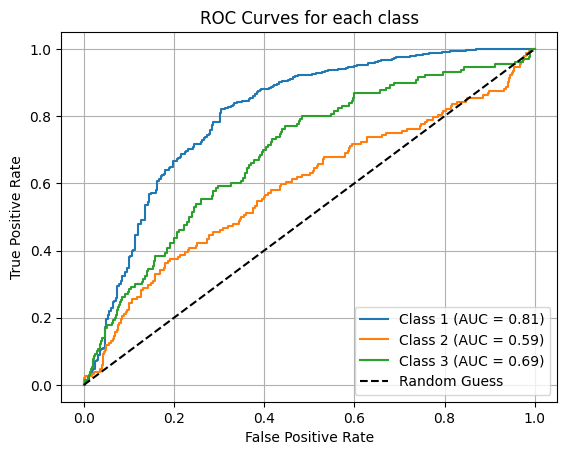


Mean F1 Score: 0.4600
Balanced Accuracy: 0.4654
Average AUPRC: 0.4460

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       760
           1       0.25      0.37      0.30       152
           2       0.29      0.19      0.23       130

    accuracy                           0.69      1042
   macro avg       0.47      0.47      0.46      1042
weighted avg       0.71      0.69      0.69      1042

Fold No: 4
Epoch [1/100], Loss: 1.1572, Accuracy: 0.3416
Validation Loss: 1.0215, Validation Accuracy: 0.3560
Epoch [2/100], Loss: 1.1140, Accuracy: 0.3853
Validation Loss: 1.2650, Validation Accuracy: 0.3500
Epoch [3/100], Loss: 1.0951, Accuracy: 0.4081
Validation Loss: 0.9853, Validation Accuracy: 0.3630
Epoch [4/100], Loss: 1.0820, Accuracy: 0.4299
Validation Loss: 1.0360, Validation Accuracy: 0.3996
Epoch [5/100], Loss: 1.0828, Accuracy: 0.4403
Validation Loss: 1.1191, Validation Accuracy: 0.4164
Epoch [6/100], Los

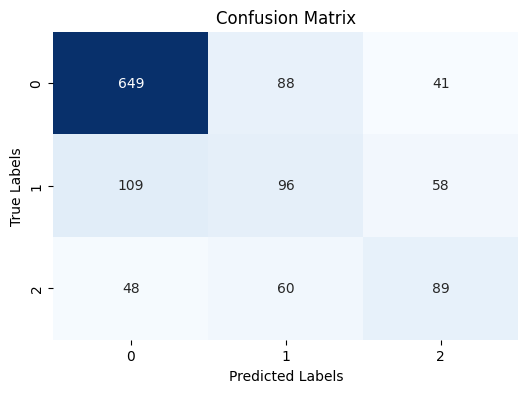


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 649/778 (83.42%)
Class 1: Correct Predictions / Total True Samples = 96/263 (36.50%)
Class 2: Correct Predictions / Total True Samples = 89/197 (45.18%)

Precision-Recall Curves:


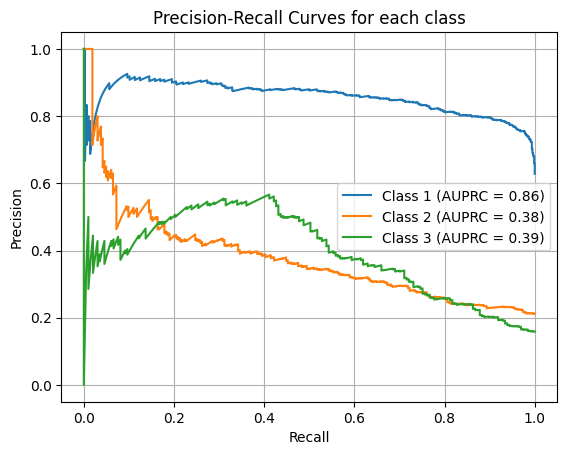


ROC Curves:


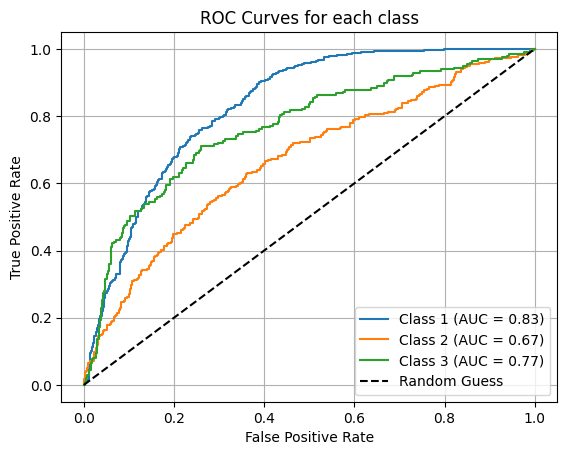


Mean F1 Score: 0.5535
Balanced Accuracy: 0.5503
Average AUPRC: 0.5406

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       778
           1       0.39      0.37      0.38       263
           2       0.47      0.45      0.46       197

    accuracy                           0.67      1238
   macro avg       0.56      0.55      0.55      1238
weighted avg       0.66      0.67      0.67      1238

Fold No: 5
Epoch [1/100], Loss: 1.2049, Accuracy: 0.3290
Validation Loss: 1.0760, Validation Accuracy: 0.3554
Epoch [2/100], Loss: 1.1103, Accuracy: 0.3646
Validation Loss: 1.0564, Validation Accuracy: 0.3386
Epoch [3/100], Loss: 1.1212, Accuracy: 0.3472
Validation Loss: 1.0747, Validation Accuracy: 0.3711
Epoch [4/100], Loss: 1.1076, Accuracy: 0.3602
Validation Loss: 1.2069, Validation Accuracy: 0.3516
Epoch [5/100], Loss: 1.1019, Accuracy: 0.3759
Validation Loss: 1.1309, Validation Accuracy: 0.4005
Epoch [6/100], Los

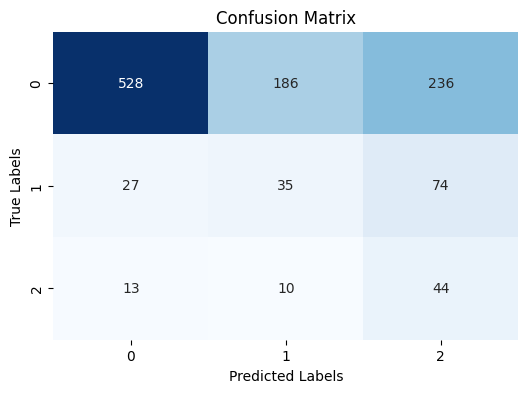


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 528/950 (55.58%)
Class 1: Correct Predictions / Total True Samples = 35/136 (25.74%)
Class 2: Correct Predictions / Total True Samples = 44/67 (65.67%)

Precision-Recall Curves:


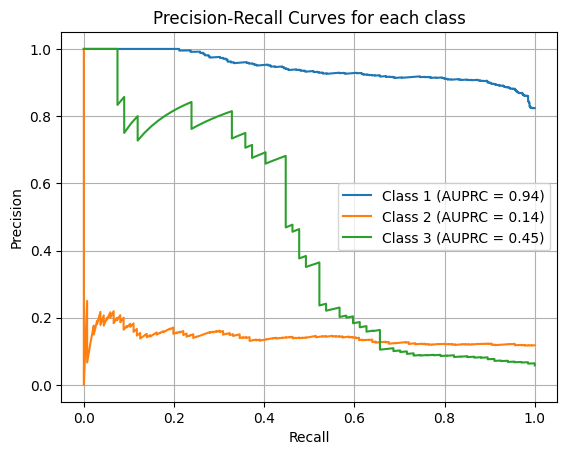


ROC Curves:


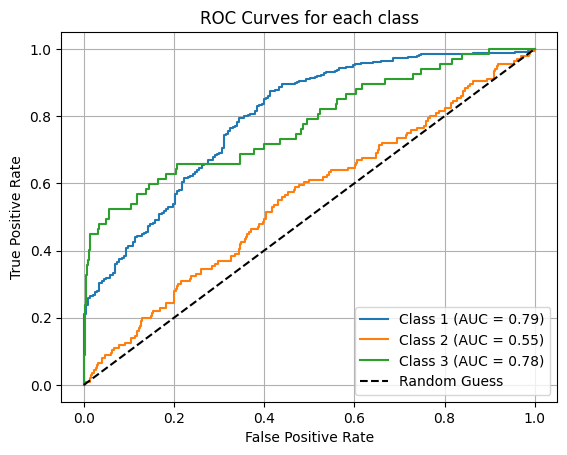


Mean F1 Score: 0.3651
Balanced Accuracy: 0.4900
Average AUPRC: 0.5097

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       950
           1       0.15      0.26      0.19       136
           2       0.12      0.66      0.21        67

    accuracy                           0.53      1153
   macro avg       0.40      0.49      0.37      1153
weighted avg       0.79      0.53      0.61      1153

Accuracy for each fold: [np.float64(0.47833524739209493), np.float64(0.5126722960456102), np.float64(0.46541835357624833), np.float64(0.5503286308385017), np.float64(0.48995294425704294)]
AUPRC for each fold: [np.float64(0.494201834988196), np.float64(0.5165469807349331), np.float64(0.4460000663561739), np.float64(0.5406363165859206), np.float64(0.5097255048593791)]
Average AUPRC across all folds: 0.5014221407049205
Average Balanced Accuracy across all folds: 0.49934149442189957
Results saved to D:\PYTHONIG\newwindow\N

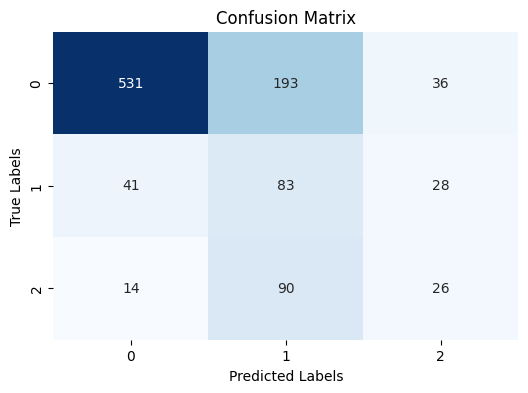


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 531/760 (69.87%)
Class 1: Correct Predictions / Total True Samples = 83/152 (54.61%)
Class 2: Correct Predictions / Total True Samples = 26/130 (20.00%)

Precision-Recall Curves:


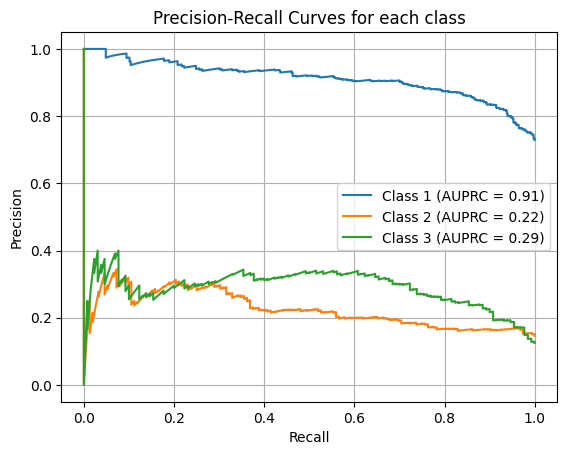


ROC Curves:


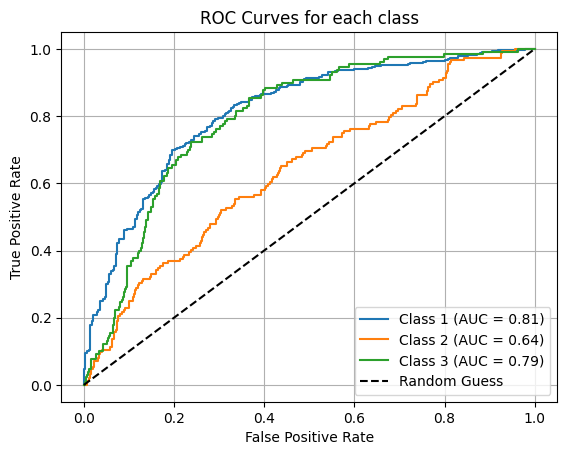


Mean F1 Score: 0.4486
Balanced Accuracy: 0.4816
Average AUPRC: 0.4743

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       760
           1       0.23      0.55      0.32       152
           2       0.29      0.20      0.24       130

    accuracy                           0.61      1042
   macro avg       0.47      0.48      0.45      1042
weighted avg       0.73      0.61      0.65      1042

Fold No: 2
Epoch [1/100], Loss: 1.1370, Accuracy: 0.3341
Validation Loss: 0.9778, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1116, Accuracy: 0.3533
Validation Loss: 1.1326, Validation Accuracy: 0.3518
Epoch [3/100], Loss: 1.0856, Accuracy: 0.4087
Validation Loss: 1.0251, Validation Accuracy: 0.4343
Epoch [4/100], Loss: 1.0376, Accuracy: 0.4974
Validation Loss: 0.9830, Validation Accuracy: 0.4737
Epoch [5/100], Loss: 1.0121, Accuracy: 0.5617
Validation Loss: 0.9653, Validation Accuracy: 0.4606
Epoch [6/100], Los

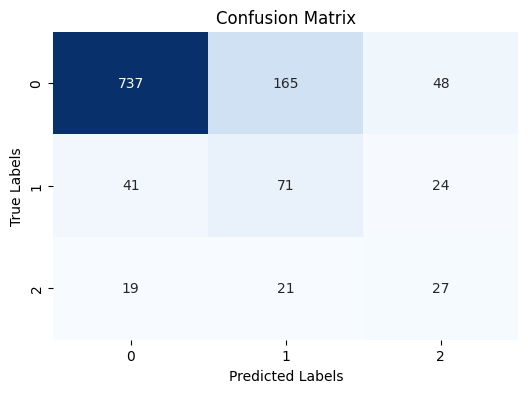


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 737/950 (77.58%)
Class 1: Correct Predictions / Total True Samples = 71/136 (52.21%)
Class 2: Correct Predictions / Total True Samples = 27/67 (40.30%)

Precision-Recall Curves:


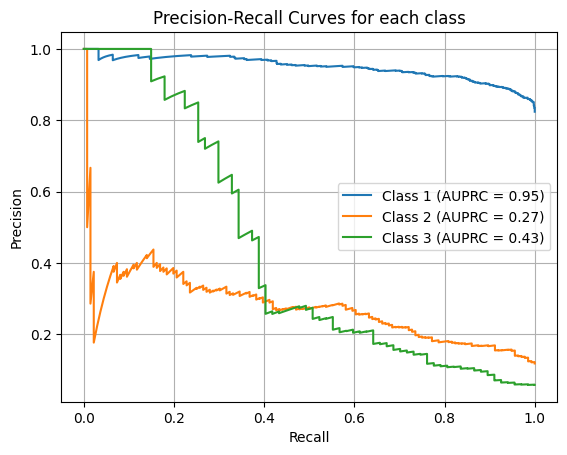


ROC Curves:


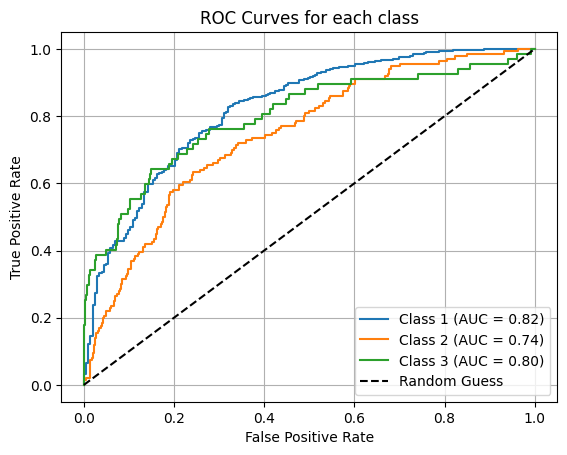


Mean F1 Score: 0.5101
Balanced Accuracy: 0.5669
Average AUPRC: 0.5499

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       950
           1       0.28      0.52      0.36       136
           2       0.27      0.40      0.33        67

    accuracy                           0.72      1153
   macro avg       0.49      0.57      0.51      1153
weighted avg       0.81      0.72      0.76      1153

Fold No: 3
Epoch [1/100], Loss: 1.1383, Accuracy: 0.3038
Validation Loss: 1.1602, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1274, Accuracy: 0.3127
Validation Loss: 1.1824, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1139, Accuracy: 0.3414
Validation Loss: 1.1097, Validation Accuracy: 0.3761
Epoch [4/100], Loss: 1.1101, Accuracy: 0.3488
Validation Loss: 1.1391, Validation Accuracy: 0.4429
Epoch [5/100], Loss: 1.0640, Accuracy: 0.4565
Validation Loss: 1.0631, Validation Accuracy: 0.4546
Epoch [6/100], Los

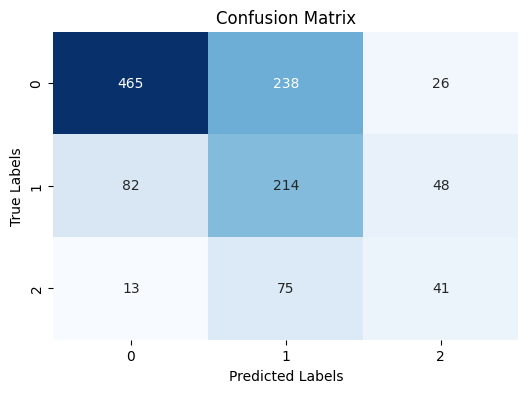


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 465/729 (63.79%)
Class 1: Correct Predictions / Total True Samples = 214/344 (62.21%)
Class 2: Correct Predictions / Total True Samples = 41/129 (31.78%)

Precision-Recall Curves:


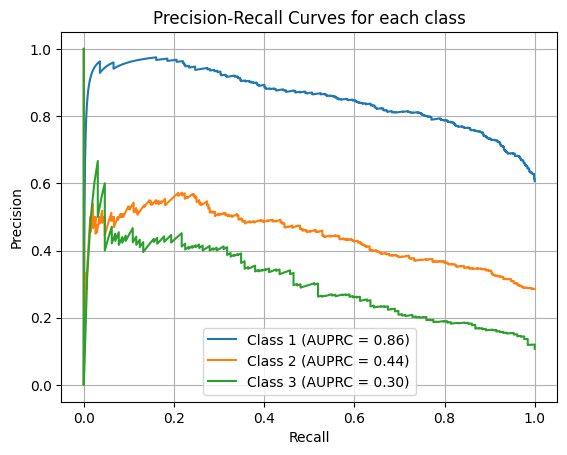


ROC Curves:


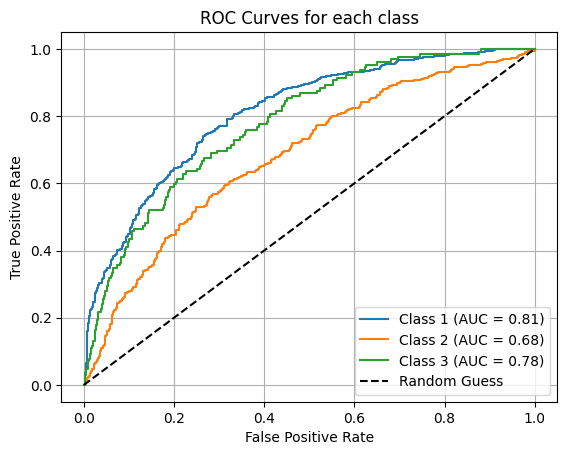


Mean F1 Score: 0.5163
Balanced Accuracy: 0.5259
Average AUPRC: 0.5329

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       729
           1       0.41      0.62      0.49       344
           2       0.36      0.32      0.34       129

    accuracy                           0.60      1202
   macro avg       0.53      0.53      0.52      1202
weighted avg       0.66      0.60      0.61      1202

Fold No: 4
Epoch [1/100], Loss: 1.1345, Accuracy: 0.3302
Validation Loss: 1.1536, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1119, Accuracy: 0.3447
Validation Loss: 1.1184, Validation Accuracy: 0.3356
Epoch [3/100], Loss: 1.1126, Accuracy: 0.3551
Validation Loss: 1.1328, Validation Accuracy: 0.3446
Epoch [4/100], Loss: 1.1128, Accuracy: 0.3230
Validation Loss: 1.0658, Validation Accuracy: 0.3376
Epoch [5/100], Loss: 1.1122, Accuracy: 0.3354
Validation Loss: 1.1403, Validation Accuracy: 0.3402
Epoch [6/100], Los

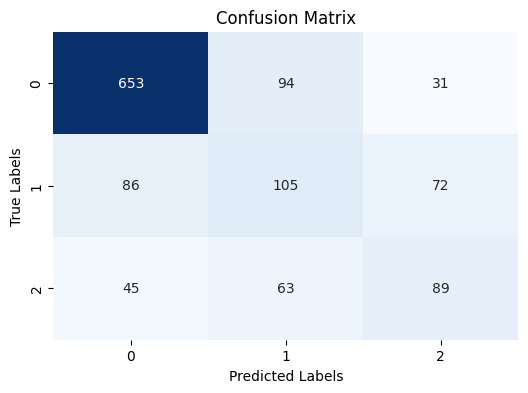


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 653/778 (83.93%)
Class 1: Correct Predictions / Total True Samples = 105/263 (39.92%)
Class 2: Correct Predictions / Total True Samples = 89/197 (45.18%)

Precision-Recall Curves:


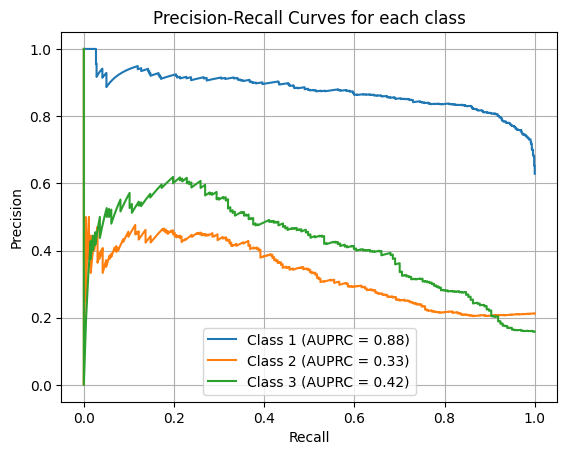


ROC Curves:


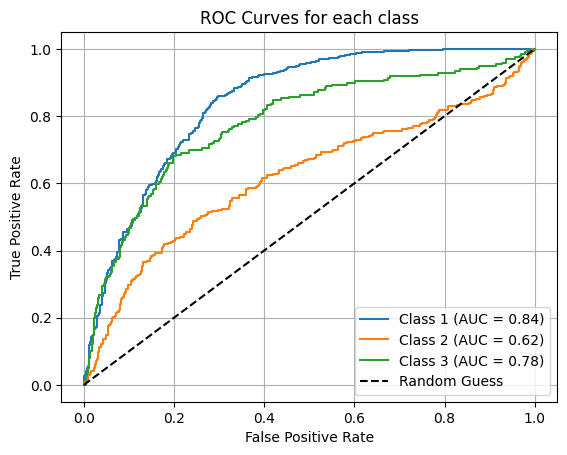


Mean F1 Score: 0.5646
Balanced Accuracy: 0.5634
Average AUPRC: 0.5407

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       778
           1       0.40      0.40      0.40       263
           2       0.46      0.45      0.46       197

    accuracy                           0.68      1238
   macro avg       0.57      0.56      0.56      1238
weighted avg       0.68      0.68      0.68      1238

Fold No: 5
Epoch [1/100], Loss: 1.1400, Accuracy: 0.3487
Validation Loss: 1.0978, Validation Accuracy: 0.4042
Epoch [2/100], Loss: 1.1089, Accuracy: 0.3783
Validation Loss: 1.1379, Validation Accuracy: 0.3784
Epoch [3/100], Loss: 1.1099, Accuracy: 0.3834
Validation Loss: 1.0820, Validation Accuracy: 0.4193
Epoch [4/100], Loss: 1.0958, Accuracy: 0.3926
Validation Loss: 1.0974, Validation Accuracy: 0.3544
Epoch [5/100], Loss: 1.0600, Accuracy: 0.4755
Validation Loss: 0.9972, Validation Accuracy: 0.4420
Epoch [6/100], Los

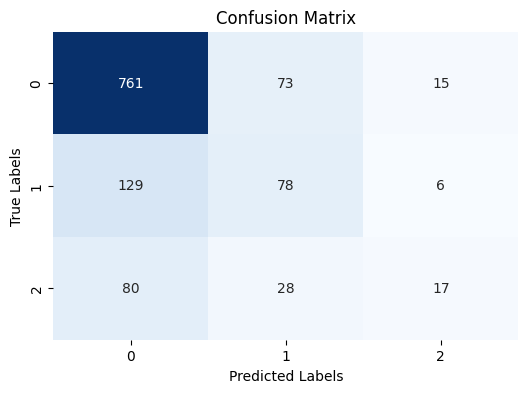


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 761/849 (89.63%)
Class 1: Correct Predictions / Total True Samples = 78/213 (36.62%)
Class 2: Correct Predictions / Total True Samples = 17/125 (13.60%)

Precision-Recall Curves:


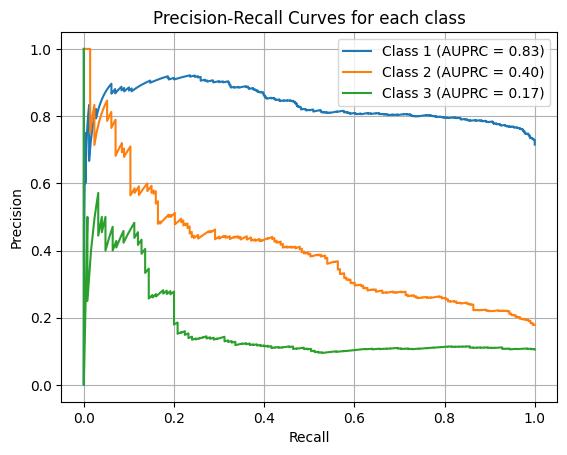


ROC Curves:


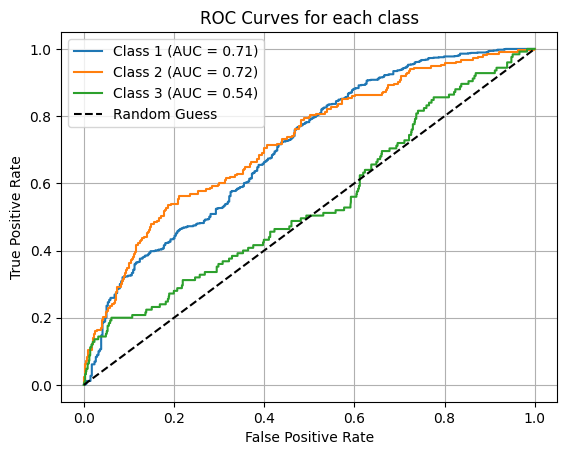


Mean F1 Score: 0.4811
Balanced Accuracy: 0.4662
Average AUPRC: 0.4676

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       849
           1       0.44      0.37      0.40       213
           2       0.45      0.14      0.21       125

    accuracy                           0.72      1187
   macro avg       0.56      0.47      0.48      1187
weighted avg       0.69      0.72      0.69      1187

Accuracy for each fold: [np.float64(0.48157894736842105), np.float64(0.5669444572801626), np.float64(0.525927520974894), np.float64(0.5634492710032345), np.float64(0.466181942854615)]
AUPRC for each fold: [np.float64(0.4742583348953673), np.float64(0.549860130552104), np.float64(0.5329148725168216), np.float64(0.540731495079241), np.float64(0.46764001870365207)]
Average AUPRC across all folds: 0.5130809703494372
Average Balanced Accuracy across all folds: 0.5208164278962654
Results saved to D:\PYTHONIG\newwindow\NOTEBO

In [9]:
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.11542281673201528, 'embed_dim': 256, 'learning_rate': 5.726209095539437e-05, 'weight_decay': 4.566099590369729e-05, 'batch_size': 16, 'num_heads': 2, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4947},
    {'hyperparameters':{'ff_dim': 512, 'dropout_rate': 0.29722015100615246, 'embed_dim': 64, 'learning_rate': 0.00046269394870735754, 'weight_decay': 0.00011711458551829446, 'batch_size': 10, 'num_heads': 4, 'num_transformer_blocks': 1}, 'mean_accuracy': 0.4893},
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.1069229904003147, 'embed_dim': 256, 'learning_rate': 0.00015525256911280537, 'weight_decay': 3.149880823421316e-05, 'batch_size': 16, 'num_heads': 4, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4884},
    {'hyperparameters':{'ff_dim': 32, 'dropout_rate': 0.10945213351235199, 'embed_dim': 256, 'learning_rate': 0.00015701457915942213, 'weight_decay': 2.5321469842206672e-05, 'batch_size': 16, 'num_heads': 4, 'num_transformer_blocks': 4}, 'mean_accuracy': 0.4841},
    {'hyperparameters':{'ff_dim': 256, 'dropout_rate': 0.2051768973953511, 'embed_dim': 128, 'learning_rate': 0.00011833585465114953, 'weight_decay': 1.384051137092256e-05, 'batch_size': 10, 'num_heads': 2, 'num_transformer_blocks': 8}, 'mean_accuracy': 0.4759}
]


for param_id in range(1,len(top_params)):
    # Fold indices and other configurations
    
    print(f"Running experiment with parameters:{param_id} {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    learning_rate = 0.0001
    epochs = 100
    input_shape = (3, 224, 224)  # (channels, height, width)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'




    embed_dim = top_params[param_id]["hyperparameters"]["embed_dim"]
    learning_rate = top_params[param_id]["hyperparameters"]["learning_rate"]
    num_heads = top_params[param_id]["hyperparameters"]["num_heads"]
    ff_dim = top_params[param_id]["hyperparameters"]["ff_dim"]
    num_transformer_blocks = top_params[param_id]["hyperparameters"]["num_transformer_blocks"]
    dropout_rate = top_params[param_id]["hyperparameters"]["dropout_rate"]
    batch_size = top_params[param_id]["hyperparameters"]["batch_size"]
    weight_decay = top_params[param_id]["hyperparameters"]["weight_decay"]

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        
        



    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TransformerModel(input_shape=input_shape, num_classes=num_classes,
                                    embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks, dropout_rate=dropout_rate).to(device)

        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
        
    # Save all results to CSV
    save_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv"
    model_description = f"TRANSformer MEL top5 param#{param_id} 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description, csv_path=save_path)
    
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)  